In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import OrdinalEncoder, normalize
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
import torch
from torch.utils.data import DataLoader
import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,fbeta_score, matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import math




#**We have separated our codes into five parts for multi-class classification problems.**
##*There are:*

**Part-1-Functions:** All functions (Evaluation Metrics, Plotting the confusion metrics, Roc-Auc Curve, Classifier models ) are created in this part. And we have not to change this code for any multi-classification problems.

**Part-2-Data Analysis & Regularization**: In this part, we will load our CSV file, and we will analyze, may remove some columns/rows, and regularize our data to make it ready for training and testing. We have to edit our data in this part.

**Part-3-Without any Sampling:** Just we will call the function for training and testing without any sampling method from this part.

**Part-4-With Oversampling:** In this part, we have used oversampling method(SMOTE) to make balance our data, and from this part, the function will be called to train and test.

**Part-5-With folding the dataset:** Here, the target dataset will be divided into n-fold, and each fold will be called to understand the performance of our model. We can use the folding method with any sampling or without any.

#***Part-1-Functions.***




###**Evaluation Metrics**

####**Functions to compute True Positives, True Negatives, False Positives and False Negatives**

In [ ]:
def true_positive(y_true, y_pred):

    tp = 0

    for yt, yp in zip(y_true, y_pred):

        if yt == 1 and yp == 1:
            tp += 1

    return tp

def true_negative(y_true, y_pred):

    tn = 0

    for yt, yp in zip(y_true, y_pred):

        if yt == 0 and yp == 0:
            tn += 1

    return tn

def false_positive(y_true, y_pred):

    fp = 0

    for yt, yp in zip(y_true, y_pred):

        if yt == 0 and yp == 1:
            fp += 1

    return fp

def false_negative(y_true, y_pred):

    fn = 0

    for yt, yp in zip(y_true, y_pred):

        if yt == 1 and yp == 0:
            fn += 1

    return fn


####**Precision and Recall**

In [ ]:
def evaluation_metrics(y_true, y_pred, y_pred_proba, cl_names,b):


     # find the number of classes
    num_classes = len(np.unique(y_true))

    # initialize tp and fp to 0
    tp_total = 0
    fp_total = 0
    tn_total = 0
    fn_total = 0

    # loop over all classes
    for class_ in np.unique(y_true):

        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]

        # calculate true positive for current class
        # and update overall tp
        tp = true_positive(temp_true, temp_pred)

        tp_total += tp

        # calculate false positive for current class
        # and update overall tp
        fp = false_positive(temp_true, temp_pred)

        fp_total += fp


        tn = true_negative(temp_true, temp_pred)

        tn_total += tn

        fn = false_negative(temp_true, temp_pred)

        fn_total += fn


        fpr = fp / (fp+tn)
        tnr = tn/ (tn+fp)
        fnr = fn / (tp+fn)


        specificity = tn/ (fp + tn)
        ac = accuracy_score(y_true, y_pred)
        precision = sklearn.metrics.precision_score(temp_true, temp_pred, average = 'macro')
        recall = sklearn.metrics.recall_score(temp_true, temp_pred, average = 'macro')
        roc_auc = roc_auc_score(temp_true, temp_pred, multi_class='ovr', average= 'macro')
        acl = accuracy_score(temp_true, temp_pred)
        f1 = sklearn.metrics.f1_score(temp_true, temp_pred, average = 'macro')
        G_Mean = math.sqrt(recall * specificity)
        f1 = sklearn.metrics.f1_score(temp_true, temp_pred, average = 'macro')

        '''print(class_)
        print("False Positive :",fp)

        print("Precision :", precision)
        print("Recall/True Positive Rate/Sensitivity :", recall)
        print("Specificity :", specificity)
        print("Roc Auc Score :", roc_auc)
        print("False Positive Rate :",fpr)
        print("True Negative Rate :",tnr)
        print("False Negative Rate :",fnr)
        print("Accuracy :", ac)
        print("G-Mean :", G_Mean)
        print("F1 Score :", f1)'''


    # calculate and return overall precision


    specificity_total = tn_total/ (fp_total + tn_total)

    precision_total = sklearn.metrics.precision_score(y_true, y_pred, average = 'macro')

    recall_total = sklearn.metrics.recall_score(y_true, y_pred, average = 'macro')

    roc_auc_total = roc_auc_score(y_true, y_pred_proba, multi_class= 'ovr', average= 'macro' )

    ac_total = accuracy_score(y_true, y_pred)

    f1_total = sklearn.metrics.f1_score(y_true, y_pred, average = 'macro')

    G_Mean_total = math.sqrt(recall_total * specificity_total)
    Log_Loss_total = log_loss(y_true, y_pred_proba, labels=b, eps=1e-15)




    fpr_total = fp_total/ (fp_total+tn_total)
    specificity_total = tn_total/ (fp_total + tn_total)
    tnr_total = tn_total / (tn_total + fp_total)
    fnr_total = fn_total / (tp_total + fn_total)

    target_names = []
    #target_names = ['Class: 1','Class: 2','Class: 3','Class: 4','Class: 5','Class: 6','Class: 7','Class: 8','Class: 9','Class: 10','Class: 11']
    for i in range(1, len(np.unique(y_true))+1):
      target_names.append('Class: ' + str(i))

    print(classification_report(y_true, y_pred, target_names=target_names))

    '''print("Accuracy :", ac_total)
    print("Log Loss :", Log_Loss_total)
    print("Precision :", precision_total)
    print("Recall/True Positive Rate/Sensitivity :", recall_total)
    print("F1 Score :", f1_total)
    print("Roc Auc Score :", roc_auc_total)
    print("Specificity :", specificity_total)
    print("Geometric Mean :", G_Mean_total)
    print("True Negative Rate :",tnr_total)
    print("False Negative Rate :",fnr_total)
    print("False Positive Rate :",fpr_total)
    print("True Positive :", tp_total)
    print("False Positive :",fp_total)
    print("True Negative :", tn_total)
    print("False Negative :", fn_total)'''


    my_dict["Classifier-Names"].append(cl_names)
    my_dict["Acc"].append(ac_total)
    my_dict["Log-Loss"].append(Log_Loss_total)
    my_dict["Precision"].append(precision_total)
    my_dict["Recall"].append(recall_total)
    my_dict["F1-Score"].append(f1_total)
    my_dict["Roc-Auc"].append(roc_auc_total)
    my_dict["Specificity"].append(specificity_total)

    my_dict["G-Mean"].append(G_Mean_total)
    my_dict["TNR"].append(tnr_total)
    my_dict["FNR"].append(fnr_total)
    my_dict["FPR"].append(fpr_total)
    my_dict["Total-TP"].append(tp_total)
    my_dict["Total-FP"].append(fp_total)
    my_dict["Total-TN"].append(tn_total)
    my_dict["Total-FN"].append(fn_total)



####**Functions for Confusion Matrics.**

In [ ]:
#For test and train data.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)

    A = (((C.T)/(C.sum(axis=1))).T)
    B = (C/C.sum(axis=0))

    plt.figure(figsize = (20,4))
    labels = [1,2,3,4,5,6,7,8,9,10,11]

    cmap = sns.light_palette("blue")
    plt.subplot(1,3,1)
    sns.heatmap(C, annot = True, cmap = cmap, fmt = ".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("Original Class")
    plt.title("Confusion matrix")

    plt.subplot(1,3,2)
    sns.heatmap(B, annot = True, cmap = cmap, fmt = ".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("Original Class")
    plt.title("Precision matrix")

    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot = True, cmap = cmap, fmt = ".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("Orziginal Class")
    plt.title("Recall matrix")

    plt.show()



####**Function for Roc-Auc Curve.**

In [ ]:
def curve(y_test, y_score, a):

  # roc curve for classes
  fpr = {}
  tpr = {}
  thresh ={}

  n_class = 11

  colors_lst = ['blue', 'yellow', 'orange', 'green', 'red', 'purple', 'brown', 'gray', 'olive', 'cyan', 'limegreen']

  # plotting
  for i in range(n_class):
      fpr[i], tpr[i], thresh[i] = sklearn.metrics.roc_curve(y_test, y_score[:,i], pos_label=i+1)

      plt.plot(fpr[i], tpr[i], linestyle='--',color= colors_lst[i], label='Class '+str(i+1))

  plt.title('Multiclass ROC curve for: '+ a)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.savefig('Multiclass ROC',dpi=300);

####**Functions for classifier models.**
####Models: (Random Forest, AdaBoost, GradientBoosting, Logistic Regression, Decision Tree, XGBoost)

In [ ]:
def train_test(X_train, X_test, y_train, y_test, p):
  bold_start = '\033[1m'
  bold_end   = '\033[0m'
  k = 0
  for i in range(50):
    if i == 0:
      classifier = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 42)
      a = 'Random Forest'

    elif i == 1:
      classifier = AdaBoostClassifier(n_estimators=20, random_state=1, learning_rate=0.01)
      a = 'AdaBoost'

    elif i == 2:
      classifier = GradientBoostingClassifier(n_estimators=20, random_state=1, learning_rate=0.01)
      a = 'Gardient Boosting'

    elif i == 3:
      classifier = LogisticRegression(solver='liblinear', multi_class='ovr')
      a = 'Logistic Regression'

    elif i == 4:
      classifier =DecisionTreeClassifier()
      a = 'Decision Tree'

    else:
      classifier = XGBClassifier (n_estimators=20, random_state=1, learning_rate=0.01)
      a = 'XGBoost'
      k = 1

    classifier.fit(X_train,y_train)
    predicted_proba_y = classifier.predict_proba(X_test)
    predicted_y = classifier.predict(X_test)

    print(bold_start, a, bold_end)
    b = classifier.classes_
    if p == 1:
      evaluation_metrics(y_test, predicted_y, predicted_proba_y,a,b)
      curve(y_test, predicted_proba_y, a)
      plot_confusion_matrix(y_test, predicted_y)

    else:
      evaluation_metrics(y_test, predicted_y, predicted_proba_y,a,b)


    if k == 1:
      break




#***Part-2-Data Analysis & Regularization:***

####**Loading csv file**

In [ ]:
import pandas as pd
import numpy as np



filename = '/content/gdrive/MyDrive/Ransomware_Benign.csv'
nlinesfile = 1554458
nlinesrandomsample = 10000
lines2skip = np.random.choice(np.arange(1,nlinesfile+1), (nlinesfile-nlinesrandomsample), replace=False)
df = pd.read_csv(filename, skiprows=lines2skip)

In [ ]:
df.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,182.22.25.252-10.42.0.211-443-52938-6,10.42.0.211,52938,182.22.25.252,443,6,21/08/2017 03:14:12,2151493,3,0,...,32,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,RANSOMWARE_JISUT
1,182.22.25.252-10.42.0.211-443-52919-6,10.42.0.211,52919,182.22.25.252,443,6,21/08/2017 03:13:56,19598082,3,1,...,32,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,RANSOMWARE_JISUT
2,224.0.0.251-10.42.0.211-5353-5353-17,10.42.0.211,5353,224.0.0.251,5353,17,21/08/2017 03:23:13,119238475,96,0,...,32,8.617077e+06,4.470538e+06,12018334.0,84.0,7.672380e+06,8.852129e+05,8015260.0,5664976.0,RANSOMWARE_JISUT
3,169.47.40.151-10.42.0.211-443-42706-6,10.42.0.211,42706,169.47.40.151,443,6,21/08/2017 03:25:36,116745964,13,10,...,32,2.585443e+05,1.456713e+05,425989.0,160971.0,3.854719e+07,1.453515e+07,46970439.0,21763485.0,RANSOMWARE_JISUT
4,219.142.78.162-10.42.0.211-443-33607-6,10.42.0.211,33607,219.142.78.162,443,6,21/08/2017 03:52:40,27540213,18,15,...,20,2.581843e+06,0.000000e+00,2581843.0,2581843.0,2.495832e+07,0.000000e+00,24958321.0,24958321.0,RANSOMWARE_JISUT


In [ ]:
columns_name = df.columns

In [ ]:
df.shape

(10000, 85)

In [ ]:
columns_name

Index(['Flow ID', ' Source IP', ' Source Port', ' Destination IP',
       ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration',
       ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Pa

In [ ]:
for i in columns_name:
  print(len(df[i].unique()))

9888
580
7741
1480
1186
3
9572
9444
153
202
1692
2294
804
71
2384
2492
525
255
2460
2348
5664
9469
9472
4734
9414
6350
6306
6310
4142
6290
4079
3447
3450
3103
3441
994
2
1
1
1
383
418
9484
6916
53
652
3034
2984
2991
2
2
1
2
2
2
1
1
8
2944
2309
2437
383
1
1
1
1
1
1
153
1692
202
2294
934
859
67
12
1076
205
1075
1076
1132
264
1132
1132
11


####**Converting the class names to numbers.**

In [ ]:
df[' Label'] = df[' Label'].map({'BENIGN':1, 'RANSOMWARE_SVPENG':2, 'RANSOMWARE_KOLER':3, 'RANSOMWARE_PORNDROID':4, 'RANSOMWARE_RANSOMBO':5, 'RANSOMWARE_CHARGER':6, 'RANSOMWARE_SIMPLOCKER':7, 'RANSOMWARE_WANNALOCKER':8, 'RANSOMWARE_LOCKERPIN':9, 'RANSOMWARE_JISUT':10, 'RANSOMWARE_PLETOR':11})

####**Analysis on our data**

In [ ]:
df[' Label'].unique()

array([10, 11,  7,  6,  4,  3,  5,  2,  9,  8,  1])

In [ ]:
df[' Label'].value_counts()

1     7731
2      372
3      306
4      290
5      262
6      253
7      218
8      201
10     181
9      148
11      38
Name:  Label, dtype: int64

####**Plot and visualize the count.**

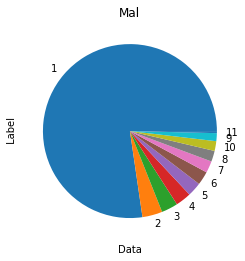

In [ ]:

plt.title('Mal')
plt.xlabel('Data')
plt.ylabel('Count')
df[' Label'].value_counts().plot(kind='pie')
plt.show()

####**Features and class lebels are separated to X and y variable.**

In [ ]:
columns = ['Flow ID', ' Source IP', ' Destination IP',' Timestamp']

In [ ]:
encoder = OrdinalEncoder()
df[columns] = encoder.fit_transform(df[columns])

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [ ]:
clean_dataset(df)

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,8290.0,4.0,52938.0,673.0,443.0,6.0,6588.0,2151493.0,3.0,0.0,...,32.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,10.0
1,8289.0,4.0,52919.0,673.0,443.0,6.0,6587.0,19598082.0,3.0,1.0,...,32.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,10.0
2,9807.0,4.0,5353.0,905.0,5353.0,17.0,6593.0,119238475.0,96.0,0.0,...,32.0,8.617077e+06,4.470538e+06,12018334.0,84.0,7.672380e+06,8.852129e+05,8015260.0,5664976.0,10.0
3,5869.0,4.0,42706.0,343.0,443.0,6.0,6597.0,116745964.0,13.0,10.0,...,32.0,2.585443e+05,1.456713e+05,425989.0,160971.0,3.854719e+07,1.453515e+07,46970439.0,21763485.0,10.0
4,9603.0,4.0,33607.0,880.0,443.0,6.0,6610.0,27540213.0,18.0,15.0,...,20.0,2.581843e+06,0.000000e+00,2581843.0,2581843.0,2.495832e+07,0.000000e+00,24958321.0,24958321.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,6333.0,3.0,53584.0,425.0,443.0,6.0,5751.0,565069.0,9.0,9.0,...,32.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1.0
9996,7397.0,3.0,34365.0,522.0,443.0,6.0,5744.0,12587602.0,9.0,10.0,...,32.0,3.823200e+05,0.000000e+00,382320.0,382320.0,1.213006e+07,0.000000e+00,12130058.0,12130058.0,1.0
9997,8416.0,3.0,55366.0,718.0,443.0,6.0,5752.0,119927571.0,13.0,14.0,...,32.0,4.094819e+06,0.000000e+00,4094819.0,4094819.0,1.158327e+08,0.000000e+00,115832711.0,115832711.0,1.0
9998,6508.0,3.0,35174.0,442.0,443.0,6.0,5755.0,148815.0,2.0,0.0,...,32.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1.0


In [ ]:
np.any(np.isnan(df))


False

In [ ]:
#np.all(np.isfinite(df))

In [ ]:
#df.fillna(0)

####**separate into input and output elements.**

In [ ]:
#df = df.drop(['Flow ID',' Source IP' ,   ' Destination IP' ,   ' Timestamp' ], axis = 1)

In [ ]:
data = df.values
X, y = data[:, :-1], data[:, -1]
y=y.astype('int')

In [ ]:
X

array([[8.29000000e+03, 4.00000000e+00, 5.29380000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.28900000e+03, 4.00000000e+00, 5.29190000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.80700000e+03, 4.00000000e+00, 5.35300000e+03, ...,
        8.85212871e+05, 8.01526000e+06, 5.66497600e+06],
       ...,
       [8.41600000e+03, 3.00000000e+00, 5.53660000e+04, ...,
        0.00000000e+00, 1.15832711e+08, 1.15832711e+08],
       [6.50800000e+03, 3.00000000e+00, 3.51740000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.19700000e+03, 3.00000000e+00, 5.76950000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [ ]:
#X = df.drop(' Label', axis = 1)
#y = df[' Label']

####**Spliting data to train and and test.**

In [ ]:
# train/test split [70-20]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 84)
(2000, 84)
(8000,)
(2000,)


####**Checking data, it is balanced or Imbalanced?**

In [ ]:
#Seeing percentage of class-0 and class-1 in train and test data...

train_distr = Counter(y_train)
print(train_distr)
train_len = len(y_train)
print(train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
print("Class 1: ",int(train_distr[1])/train_len, "Class 2: ", int(train_distr[2])/train_len, "Class 3: ", int(train_distr[3])/train_len, "Class 4: ", int(train_distr[4])/train_len, "Class 5: ", int(train_distr[5])/train_len, "Class 6: ",int(train_distr[6])/train_len, "Class 7: ", int(train_distr[7])/train_len, "Class 8: ", int(train_distr[8])/train_len, "Class 9: ", int(train_distr[9])/train_len, "Class 10: ", int(train_distr[10])/train_len, "Class 11: ", int(train_distr[11])/train_len)
print("-"*10, "Distribution of output variable in test data", "-" * 10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 1: ",int(test_distr[1])/test_len, "Class 2: ",int(test_distr[2])/test_len, "Class 3: ",int(test_distr[3])/test_len, "Class 4: ",int(test_distr[4])/test_len, "Class 5: ",int(test_distr[5])/test_len, "Class 6: ",int(test_distr[6])/test_len, "Class 7: ", int(test_distr[7])/test_len, "Class 8: ", int(test_distr[8])/test_len, "Class 9: ", int(test_distr[9])/test_len, "Class 10: ", int(test_distr[10])/test_len, "Class 11: ", int(test_distr[11])/test_len)

Counter({1: 6198, 2: 295, 3: 242, 4: 229, 5: 208, 6: 199, 7: 172, 8: 155, 10: 140, 9: 128, 11: 34})
8000
---------- Distribution of output variable in train data ----------
Class 1:  0.77475 Class 2:  0.036875 Class 3:  0.03025 Class 4:  0.028625 Class 5:  0.026 Class 6:  0.024875 Class 7:  0.0215 Class 8:  0.019375 Class 9:  0.016 Class 10:  0.0175 Class 11:  0.00425
---------- Distribution of output variable in test data ----------
Class 1:  0.7665 Class 2:  0.0385 Class 3:  0.032 Class 4:  0.0305 Class 5:  0.027 Class 6:  0.027 Class 7:  0.023 Class 8:  0.023 Class 9:  0.01 Class 10:  0.0205 Class 11:  0.002


####**Seeing logloss For Random model, as though we can compare our classifier to this Random mode.**

In [ ]:
from sklearn.metrics import log_loss

In [ ]:
predicted_y = np.zeros((test_len,11))
for i in range(test_len):
    rand_probs = np.random.rand(1,11)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))


Log loss on Test Data using Random Model 2.6953319975741006


#***Part-3-Train and Test Without any sampling method.***

In [ ]:
X_train.shape

(8000, 84)

 Random Forest 
              precision    recall  f1-score   support

    Class: 1       0.94      0.99      0.96      1533
    Class: 2       0.80      0.90      0.85        77
    Class: 3       0.79      0.64      0.71        64
    Class: 4       0.75      0.67      0.71        61
    Class: 5       0.77      0.85      0.81        54
    Class: 6       0.75      0.67      0.71        54
    Class: 7       0.71      0.65      0.68        46
    Class: 8       0.82      0.20      0.32        46
    Class: 9       0.41      0.35      0.38        20
   Class: 10       0.60      0.07      0.13        41
   Class: 11       0.00      0.00      0.00         4

    accuracy                           0.90      2000
   macro avg       0.67      0.54      0.57      2000
weighted avg       0.89      0.90      0.89      2000



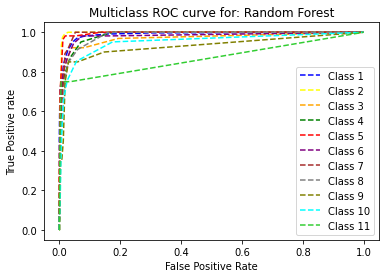

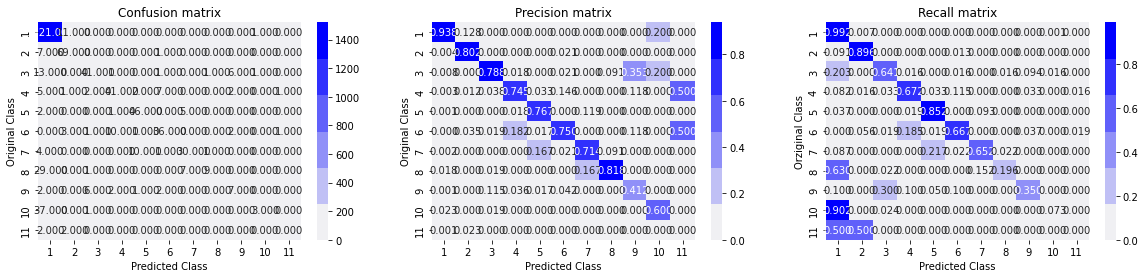

 AdaBoost 
              precision    recall  f1-score   support

    Class: 1       0.95      0.99      0.97      1533
    Class: 2       0.25      1.00      0.39        77
    Class: 3       0.57      0.86      0.69        64
    Class: 4       0.00      0.00      0.00        61
    Class: 5       0.00      0.00      0.00        54
    Class: 6       0.00      0.00      0.00        54
    Class: 7       0.00      0.00      0.00        46
    Class: 8       0.00      0.00      0.00        46
    Class: 9       0.00      0.00      0.00        20
   Class: 10       0.00      0.00      0.00        41
   Class: 11       0.00      0.00      0.00         4

    accuracy                           0.82      2000
   macro avg       0.16      0.26      0.19      2000
weighted avg       0.76      0.82      0.78      2000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

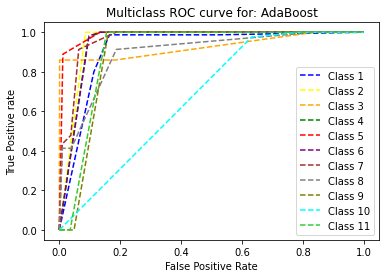

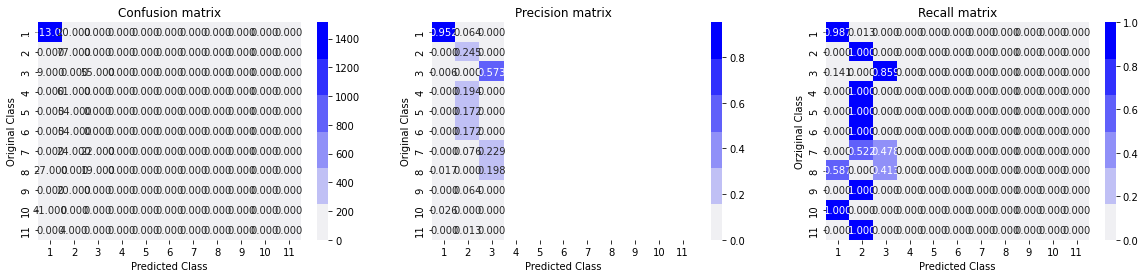

 Gardient Boosting 
              precision    recall  f1-score   support

    Class: 1       0.77      1.00      0.87      1533
    Class: 2       0.00      0.00      0.00        77
    Class: 3       0.00      0.00      0.00        64
    Class: 4       0.00      0.00      0.00        61
    Class: 5       0.00      0.00      0.00        54
    Class: 6       0.00      0.00      0.00        54
    Class: 7       0.00      0.00      0.00        46
    Class: 8       0.00      0.00      0.00        46
    Class: 9       0.00      0.00      0.00        20
   Class: 10       0.00      0.00      0.00        41
   Class: 11       0.00      0.00      0.00         4

    accuracy                           0.77      2000
   macro avg       0.07      0.09      0.08      2000
weighted avg       0.59      0.77      0.67      2000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

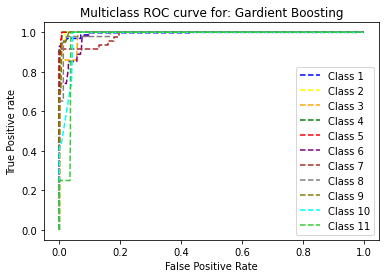

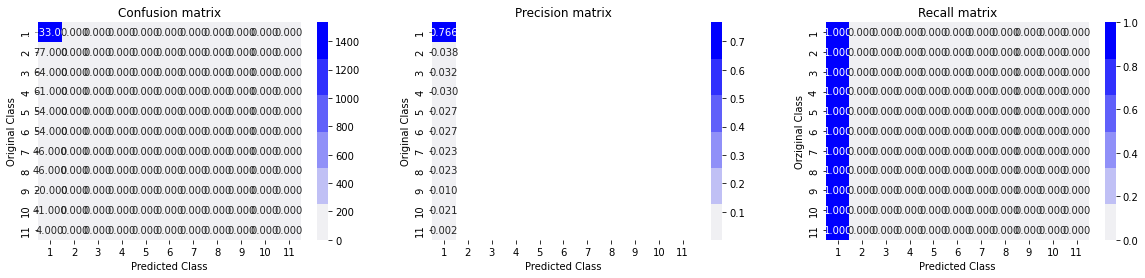

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 Logistic Regression 


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

              precision    recall  f1-score   support

    Class: 1       0.77      1.00      0.87      1533
    Class: 2       0.50      0.01      0.03        77
    Class: 3       0.00      0.00      0.00        64
    Class: 4       0.00      0.00      0.00        61
    Class: 5       0.00      0.00      0.00        54
    Class: 6       0.00      0.00      0.00        54
    Class: 7       0.00      0.00      0.00        46
    Class: 8       0.00      0.00      0.00        46
    Class: 9       0.00      0.00      0.00        20
   Class: 10       0.00      0.00      0.00        41
   Class: 11       0.00      0.00      0.00         4

    accuracy                           0.77      2000
   macro avg       0.12      0.09      0.08      2000
weighted avg       0.61      0.77      0.67      2000



<ipython-input-6-504b423498f2>:6: RuntimeWarning: invalid value encountered in true_divide
  B = (C/C.sum(axis=0))


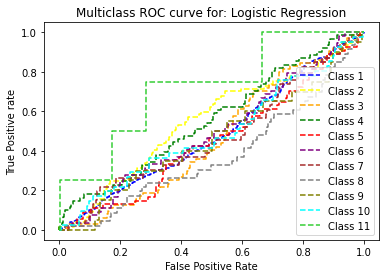

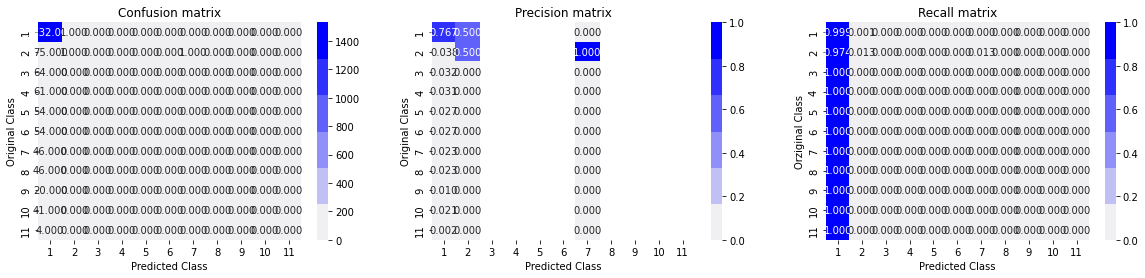

 Decision Tree 
              precision    recall  f1-score   support

    Class: 1       1.00      1.00      1.00      1533
    Class: 2       0.97      0.99      0.98        77
    Class: 3       0.98      1.00      0.99        64
    Class: 4       0.97      0.95      0.96        61
    Class: 5       0.96      0.98      0.97        54
    Class: 6       0.98      0.94      0.96        54
    Class: 7       0.96      0.96      0.96        46
    Class: 8       0.98      1.00      0.99        46
    Class: 9       0.95      0.90      0.92        20
   Class: 10       1.00      0.95      0.97        41
   Class: 11       0.67      1.00      0.80         4

    accuracy                           0.99      2000
   macro avg       0.95      0.97      0.96      2000
weighted avg       0.99      0.99      0.99      2000



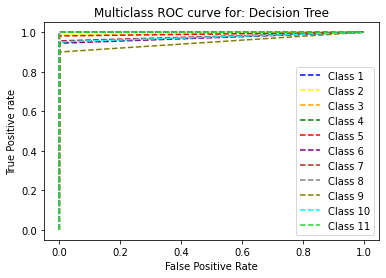

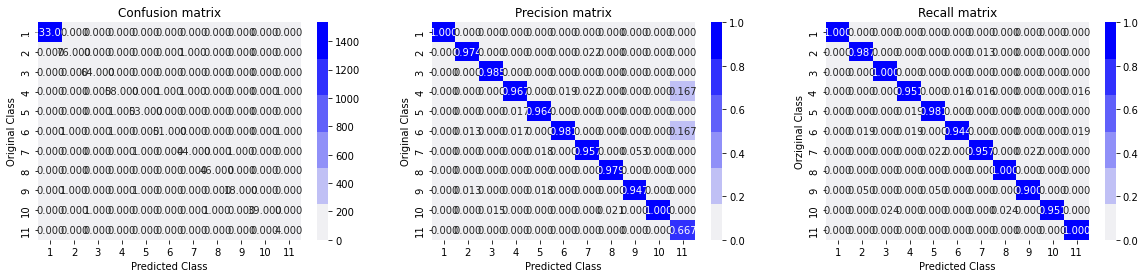

 XGBoost 
              precision    recall  f1-score   support

    Class: 1       0.97      1.00      0.98      1533
    Class: 2       0.82      0.94      0.87        77
    Class: 3       0.75      0.86      0.80        64
    Class: 4       0.93      0.90      0.92        61
    Class: 5       0.94      0.89      0.91        54
    Class: 6       0.89      0.74      0.81        54
    Class: 7       0.98      0.87      0.92        46
    Class: 8       0.93      0.57      0.70        46
    Class: 9       0.88      0.70      0.78        20
   Class: 10       1.00      0.37      0.54        41
   Class: 11       1.00      0.25      0.40         4

    accuracy                           0.95      2000
   macro avg       0.92      0.73      0.78      2000
weighted avg       0.95      0.95      0.94      2000



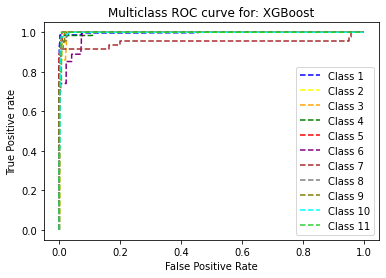

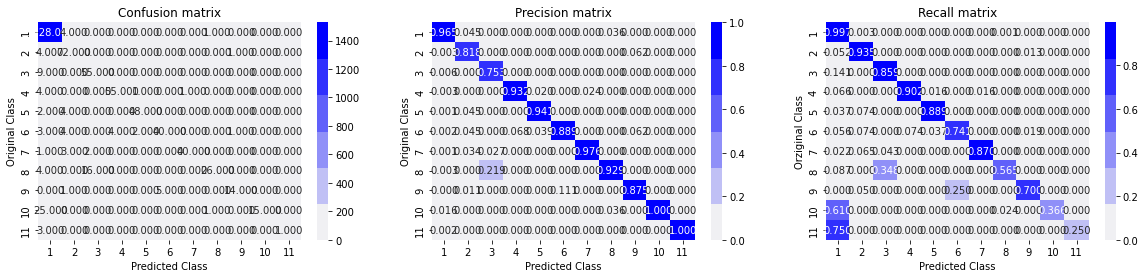

In [ ]:
my_dict = {'Classifier-Names': [], 'Acc': [], 'Log-Loss': [],  'Precision': [],  'Recall': [],  'F1-Score': [], 'Roc-Auc': [] , 'Specificity': [], 'G-Mean' : [], 'TNR': [], 'FNR' : [], 'FPR': [], 'Total-TP': [],  'Total-FP': [], 'Total-TN' : [], 'Total-FN' : []}

train_test(X_train, X_test, y_train, y_test, 1)

####**Save and Read the table of Evaluation Matrics.**

In [ ]:
data = pd.DataFrame(my_dict)
data.to_csv('/content/gdrive/MyDrive/Ransom_Benign_Without_Oversampling.csv', encoding='utf-8', index=False)
data = pd.read_csv('/content/gdrive/MyDrive/Ransom_Benign_Without_Oversampling.csv')
data.head()

,Classifier-Names,Acc,Log-Loss,Precision,Recall,F1-Score,Roc-Auc,Specificity,G-Mean,TNR,FNR,FPR,Total-TP,Total-FP,Total-TN,Total-FN
0,Random Forest,0.9015,0.463174,0.666807,0.544595,0.567629,0.966704,0.99015,0.734323,0.99015,0.0985,0.00985,1803,197,19803,197
1,AdaBoost,0.8225,0.561987,0.160883,0.258757,0.186391,0.911333,0.98225,0.504147,0.98225,0.1775,0.01775,1645,355,19645,355
2,Gardient Boosting,0.7665,0.595835,0.069682,0.090909,0.078893,0.990606,0.97665,0.297970,0.97665,0.2335,0.02335,1533,467,19533,467
3,Logistic Regression,0.7665,1.889089,0.115196,0.092030,0.081210,0.500339,0.97665,0.299802,0.97665,0.2335,0.02335,1533,467,19533,467
4,Decision Tree,0.9930,0.241771,0.947212,0.970136,0.955469,0.984742,0.99930,0.984610,0.99930,0.0070,0.00070,1986,14,19986,14


#***Part-4-Train and Test With oversampling method.***

##**SMOTE Technique for Oversampling the Data.**

Class=10, n=7731 (77.310%)
Class=11, n=7731 (77.310%)
Class=7, n=7731 (77.310%)
Class=6, n=7731 (77.310%)
Class=4, n=7731 (77.310%)
Class=3, n=7731 (77.310%)
Class=5, n=7731 (77.310%)
Class=2, n=7731 (77.310%)
Class=9, n=7731 (77.310%)
Class=8, n=7731 (77.310%)
Class=1, n=7731 (77.310%)


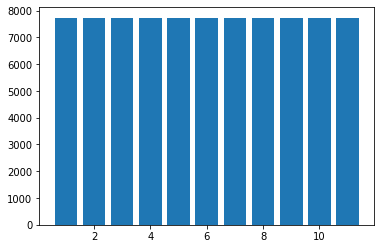

In [ ]:
from pandas import read_csv
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder


oversample = SMOTE()
X2, y2 = oversample.fit_resample(X, y)
# summarize distribution
counter = Counter(y2)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution

#y2 = pd.Series(y2)
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

####**Spliting data to train and and test.**

In [ ]:
# train/test split [70-20]
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.20, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(68032, 84)
(17009, 84)
(68032,)
(17009,)


####**Calling the function to train and test.**



 Random Forest 
              precision    recall  f1-score   support

    Class: 1       1.00      0.97      0.98      1537
    Class: 2       0.99      1.00      1.00      1518
    Class: 3       0.99      1.00      0.99      1505
    Class: 4       1.00      1.00      1.00      1564
    Class: 5       0.99      1.00      0.99      1608
    Class: 6       1.00      0.99      1.00      1564
    Class: 7       1.00      0.99      0.99      1496
    Class: 8       0.99      1.00      0.99      1549
    Class: 9       1.00      1.00      1.00      1546
   Class: 10       0.99      1.00      1.00      1554
   Class: 11       1.00      1.00      1.00      1568

    accuracy                           0.99     17009
   macro avg       0.99      0.99      0.99     17009
weighted avg       0.99      0.99      0.99     17009



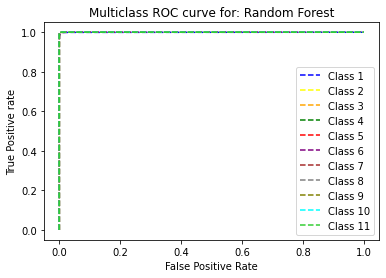

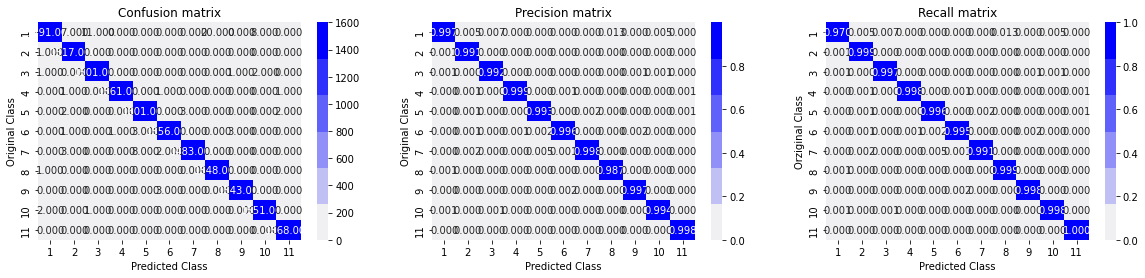

 AdaBoost 


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

              precision    recall  f1-score   support

    Class: 1       0.00      0.00      0.00      1537
    Class: 2       0.36      0.51      0.42      1518
    Class: 3       0.30      0.86      0.45      1505
    Class: 4       0.46      0.98      0.62      1564
    Class: 5       0.84      0.35      0.49      1608
    Class: 6       0.00      0.00      0.00      1564
    Class: 7       0.60      0.84      0.70      1496
    Class: 8       0.77      0.84      0.80      1549
    Class: 9       0.56      0.99      0.71      1546
   Class: 10       0.00      0.00      0.00      1554
   Class: 11       0.00      0.00      0.00      1568

    accuracy                           0.49     17009
   macro avg       0.35      0.49      0.38     17009
weighted avg       0.35      0.49      0.38     17009



<ipython-input-6-504b423498f2>:6: RuntimeWarning: invalid value encountered in true_divide
  B = (C/C.sum(axis=0))


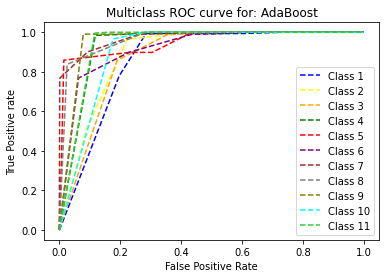

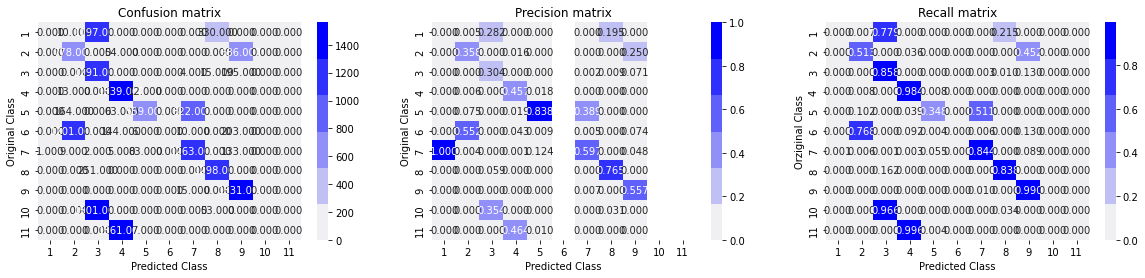

 Gardient Boosting 
              precision    recall  f1-score   support

    Class: 1       1.00      0.91      0.95      1537
    Class: 2       0.99      0.81      0.89      1518
    Class: 3       0.86      0.93      0.89      1505
    Class: 4       0.89      0.95      0.92      1564
    Class: 5       0.88      0.86      0.87      1608
    Class: 6       0.68      0.86      0.76      1564
    Class: 7       0.97      0.79      0.87      1496
    Class: 8       0.92      0.87      0.90      1549
    Class: 9       0.88      0.80      0.84      1546
   Class: 10       0.84      0.97      0.90      1554
   Class: 11       0.91      0.98      0.95      1568

    accuracy                           0.88     17009
   macro avg       0.89      0.88      0.89     17009
weighted avg       0.89      0.88      0.89     17009



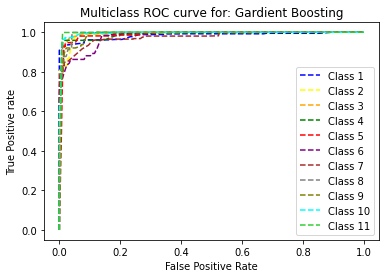

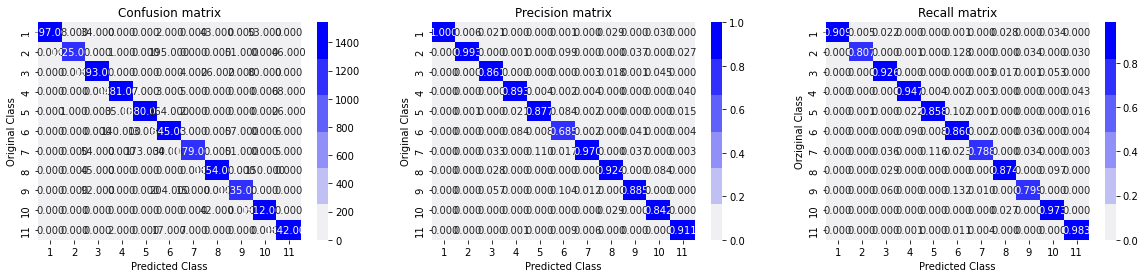

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 Logistic Regression 
              precision    recall  f1-score   support

    Class: 1       0.13      0.03      0.04      1537
    Class: 2       0.10      0.64      0.18      1518
    Class: 3       0.15      0.06      0.08      1505
    Class: 4       0.13      0.07      0.10      1564
    Class: 5       0.15      0.13      0.14      1608
    Class: 6       0.26      0.03      0.06      1564
    Class: 7       0.13      0.05      0.07      1496
    Class: 8       0.19      0.17      0.18      1549
    Class: 9       0.22      0.04      0.06      1546
   Class: 10       0.16      0.14      0.15      1554
   Class: 11       0.74      0.28      0.41      1568

    accuracy                           0.15     17009
   macro avg       0.22      0.15      0.13     17009
weighted avg       0.22      0.15      0.13     17009



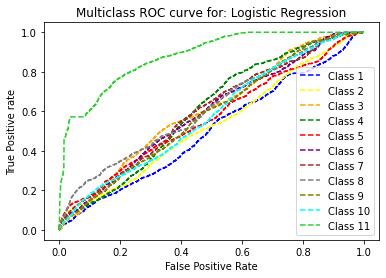

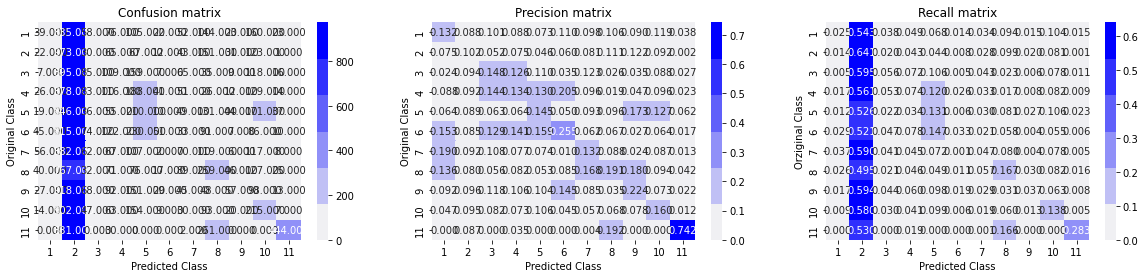

 Decision Tree 
              precision    recall  f1-score   support

    Class: 1       0.98      0.97      0.97      1537
    Class: 2       0.99      0.99      0.99      1518
    Class: 3       0.98      0.99      0.99      1505
    Class: 4       0.99      0.99      0.99      1564
    Class: 5       0.98      0.99      0.98      1608
    Class: 6       0.99      0.98      0.98      1564
    Class: 7       0.99      0.97      0.98      1496
    Class: 8       0.98      0.99      0.98      1549
    Class: 9       0.99      1.00      0.99      1546
   Class: 10       0.99      0.99      0.99      1554
   Class: 11       1.00      1.00      1.00      1568

    accuracy                           0.99     17009
   macro avg       0.99      0.99      0.99     17009
weighted avg       0.99      0.99      0.99     17009



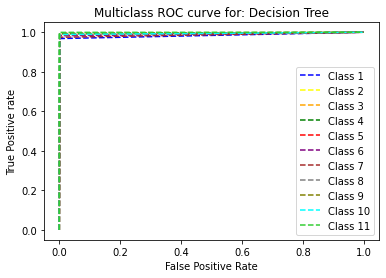

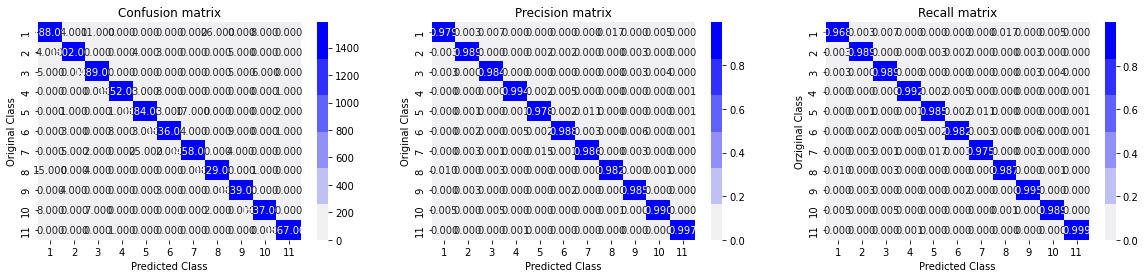

 XGBoost 
              precision    recall  f1-score   support

    Class: 1       1.00      0.91      0.95      1537
    Class: 2       0.99      0.81      0.89      1518
    Class: 3       0.83      0.93      0.88      1505
    Class: 4       0.89      0.95      0.92      1564
    Class: 5       0.88      0.86      0.87      1608
    Class: 6       0.69      0.86      0.77      1564
    Class: 7       0.97      0.79      0.87      1496
    Class: 8       0.93      0.84      0.88      1549
    Class: 9       0.84      0.77      0.80      1546
   Class: 10       0.84      0.97      0.90      1554
   Class: 11       0.91      0.98      0.95      1568

    accuracy                           0.88     17009
   macro avg       0.89      0.88      0.88     17009
weighted avg       0.89      0.88      0.88     17009



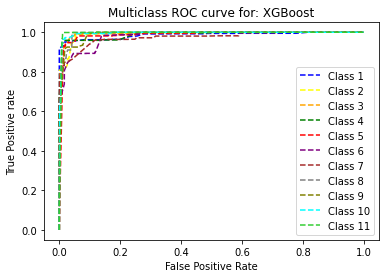

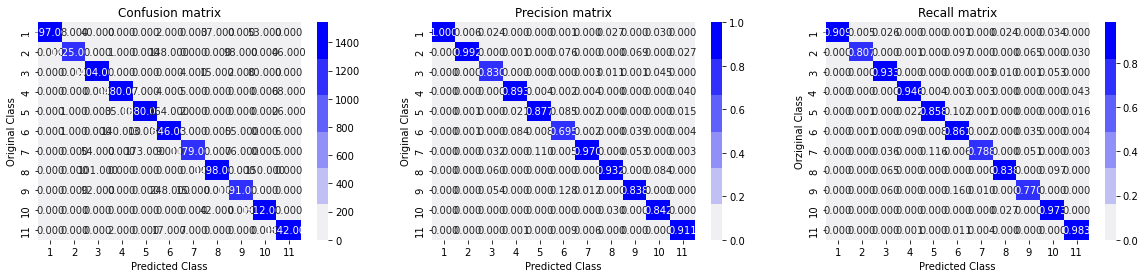

In [ ]:
my_dict = {'Classifier-Names': [], 'Acc': [], 'Log-Loss': [],  'Precision': [],  'Recall': [],  'F1-Score': [], 'Roc-Auc': [] , 'Specificity': [], 'G-Mean' : [], 'TNR': [], 'FNR' : [], 'FPR': [], 'Total-TP': [],  'Total-FP': [], 'Total-TN' : [], 'Total-FN' : []}

train_test(X_train, X_test, y_train, y_test,1)

####**Save and Read the table of Evaluation Matrics.**

In [ ]:
data = pd.DataFrame(my_dict)
data.to_csv('/content/gdrive/MyDrive/Ransom_Benign_with_oversample_SMOTE.csv', encoding='utf-8', index=False)
data = pd.read_csv('/content/gdrive/MyDrive/Ransom_Benign_with_oversample_SMOTE.csv')
data.head()

,Classifier-Names,Acc,Log-Loss,Precision,Recall,F1-Score,Roc-Auc,Specificity,G-Mean,TNR,FNR,FPR,Total-TP,Total-FP,Total-TN,Total-FN
0,Random Forest,0.994767,0.079121,0.994782,0.994742,0.994738,0.999945,0.999477,0.997107,0.999477,0.005233,0.000523,16920,89,170001,89
1,AdaBoost,0.485566,1.243331,0.352477,0.488590,0.381745,0.926635,0.948557,0.680775,0.948557,0.514434,0.051443,8259,8750,161340,8750
2,Gardient Boosting,0.884414,1.546849,0.894628,0.884003,0.885481,0.988624,0.988441,0.934765,0.988441,0.115586,0.011559,15043,1966,168124,1966
3,Logistic Regression,0.148098,2.298129,0.215009,0.148417,0.132728,0.603590,0.914810,0.368474,0.914810,0.851902,0.085190,2519,14490,155600,14490
4,Decision Tree,0.986595,0.462981,0.986594,0.986548,0.986560,0.992604,0.998660,0.992585,0.998660,0.013405,0.001340,16781,228,169862,228


##**BorderlineSMOTE Technique for oversampling**

Class=10, n=7731 (77.310%)
Class=11, n=7731 (77.310%)
Class=7, n=7731 (77.310%)
Class=6, n=7731 (77.310%)
Class=4, n=7731 (77.310%)
Class=3, n=7731 (77.310%)
Class=5, n=7731 (77.310%)
Class=2, n=7731 (77.310%)
Class=9, n=7731 (77.310%)
Class=8, n=7731 (77.310%)
Class=1, n=7731 (77.310%)


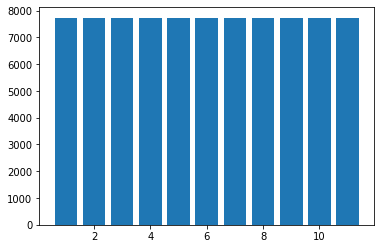

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
#X2, y2 = oversample.fit_resample(X, y)
X_borderline, y_borderline = BorderlineSMOTE().fit_resample(X,y)

minority_index_after = y_borderline==1
m_borderline = np.mean(X_borderline[minority_index_after],axis=0)
std_borderline = np.std(X_borderline[minority_index_after],axis=0)

counter = Counter(y_borderline)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution

#y2 = pd.Series(y2)
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

####**Spliting data to train and and test.**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_borderline, y_borderline, stratify = y_borderline, test_size = 0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(68032, 84)
(17009, 84)
(68032,)
(17009,)


####**Calling the function to train and test.**



 Random Forest 
              precision    recall  f1-score   support

    Class: 1       0.96      0.98      0.97      1547
    Class: 2       0.99      1.00      0.99      1547
    Class: 3       0.99      0.99      0.99      1546
    Class: 4       0.99      0.99      0.99      1546
    Class: 5       0.99      0.99      0.99      1546
    Class: 6       0.99      0.99      0.99      1546
    Class: 7       0.99      1.00      0.99      1546
    Class: 8       0.99      0.99      0.99      1546
    Class: 9       1.00      0.99      0.99      1546
   Class: 10       1.00      0.99      0.99      1547
   Class: 11       1.00      1.00      1.00      1546

    accuracy                           0.99     17009
   macro avg       0.99      0.99      0.99     17009
weighted avg       0.99      0.99      0.99     17009



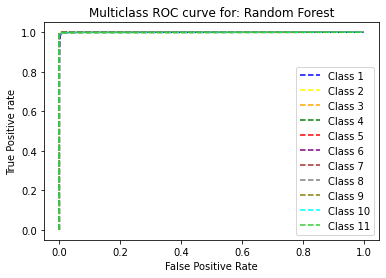

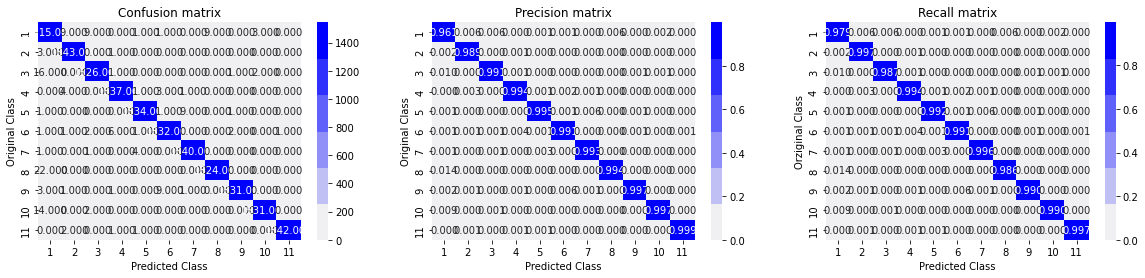

 AdaBoost 


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

              precision    recall  f1-score   support

    Class: 1       0.00      0.00      0.00      1547
    Class: 2       0.68      0.05      0.09      1547
    Class: 3       0.32      0.90      0.47      1546
    Class: 4       0.00      0.00      0.00      1546
    Class: 5       0.87      0.88      0.88      1546
    Class: 6       0.57      0.80      0.66      1546
    Class: 7       0.99      0.77      0.87      1546
    Class: 8       0.73      0.80      0.77      1546
    Class: 9       0.59      0.99      0.74      1546
   Class: 10       0.00      0.00      0.00      1547
   Class: 11       0.47      1.00      0.63      1546

    accuracy                           0.56     17009
   macro avg       0.47      0.56      0.46     17009
weighted avg       0.47      0.56      0.46     17009



<ipython-input-6-504b423498f2>:6: RuntimeWarning: invalid value encountered in true_divide
  B = (C/C.sum(axis=0))


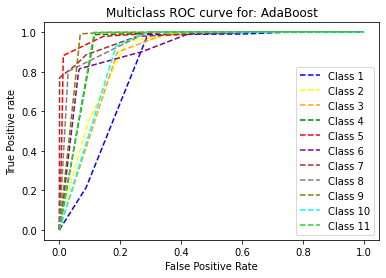

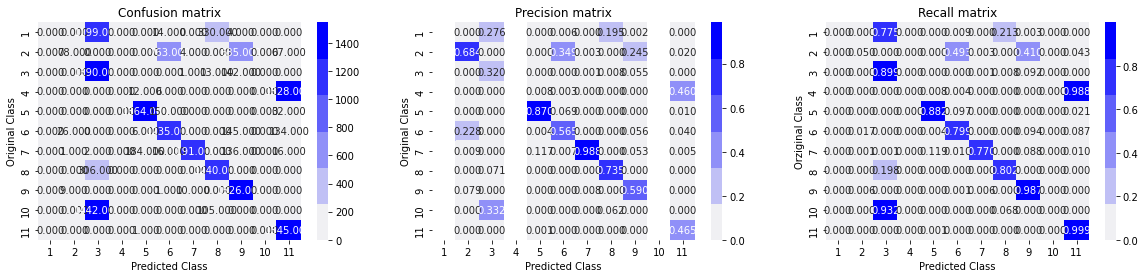

 Gardient Boosting 
              precision    recall  f1-score   support

    Class: 1       1.00      0.90      0.95      1547
    Class: 2       0.98      0.85      0.91      1547
    Class: 3       0.86      0.95      0.90      1546
    Class: 4       0.90      0.99      0.94      1546
    Class: 5       0.87      0.94      0.91      1546
    Class: 6       0.84      0.83      0.84      1546
    Class: 7       0.92      0.78      0.84      1546
    Class: 8       0.91      0.86      0.88      1546
    Class: 9       0.84      0.92      0.88      1546
   Class: 10       0.86      0.96      0.91      1547
   Class: 11       1.00      1.00      1.00      1546

    accuracy                           0.91     17009
   macro avg       0.91      0.91      0.91     17009
weighted avg       0.91      0.91      0.91     17009



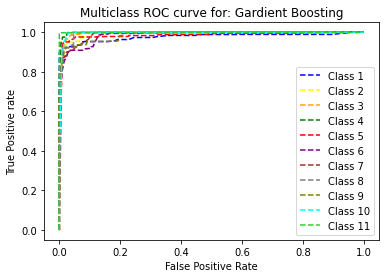

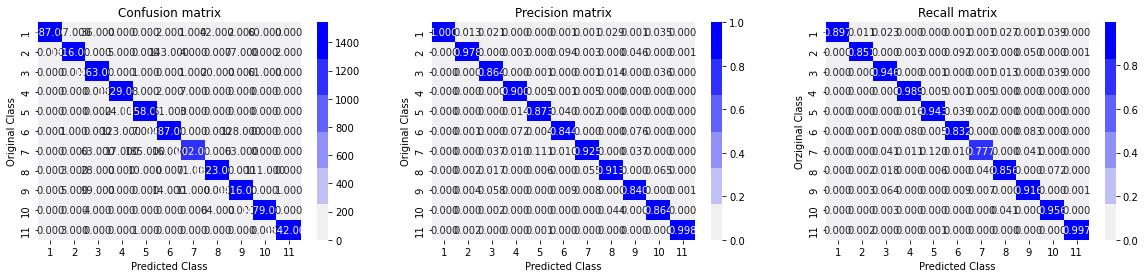

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 Logistic Regression 
              precision    recall  f1-score   support

    Class: 1       0.13      0.02      0.04      1547
    Class: 2       0.50      0.12      0.19      1547
    Class: 3       0.25      0.10      0.15      1546
    Class: 4       0.52      0.09      0.15      1546
    Class: 5       0.10      0.19      0.13      1546
    Class: 6       0.41      0.09      0.15      1546
    Class: 7       0.29      0.18      0.22      1546
    Class: 8       0.37      0.37      0.37      1546
    Class: 9       0.30      0.06      0.10      1546
   Class: 10       0.15      0.78      0.25      1547
   Class: 11       0.96      1.00      0.98      1546

    accuracy                           0.27     17009
   macro avg       0.36      0.27      0.25     17009
weighted avg       0.36      0.27      0.25     17009



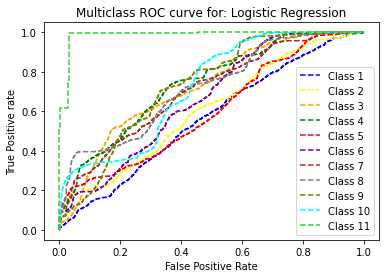

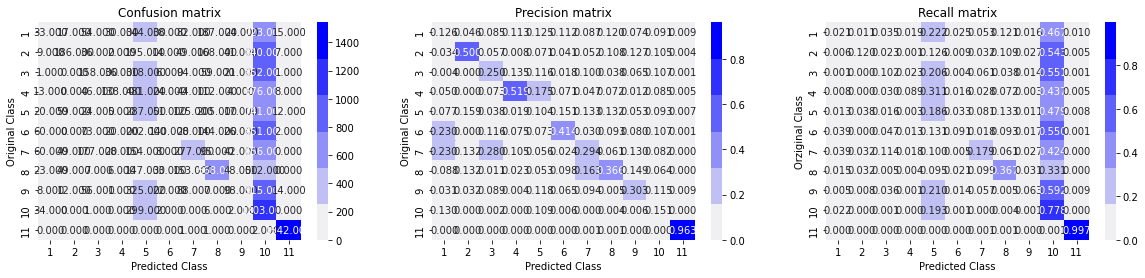

 Decision Tree 
              precision    recall  f1-score   support

    Class: 1       0.98      0.97      0.98      1547
    Class: 2       0.99      0.99      0.99      1547
    Class: 3       0.99      0.99      0.99      1546
    Class: 4       1.00      1.00      1.00      1546
    Class: 5       0.99      1.00      0.99      1546
    Class: 6       0.99      1.00      1.00      1546
    Class: 7       0.99      1.00      0.99      1546
    Class: 8       0.99      0.99      0.99      1546
    Class: 9       1.00      0.99      0.99      1546
   Class: 10       0.99      0.99      0.99      1547
   Class: 11       1.00      1.00      1.00      1546

    accuracy                           0.99     17009
   macro avg       0.99      0.99      0.99     17009
weighted avg       0.99      0.99      0.99     17009



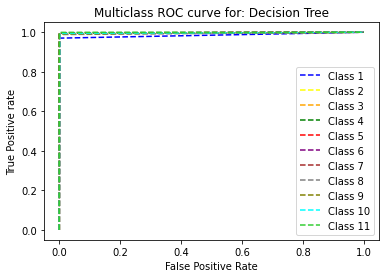

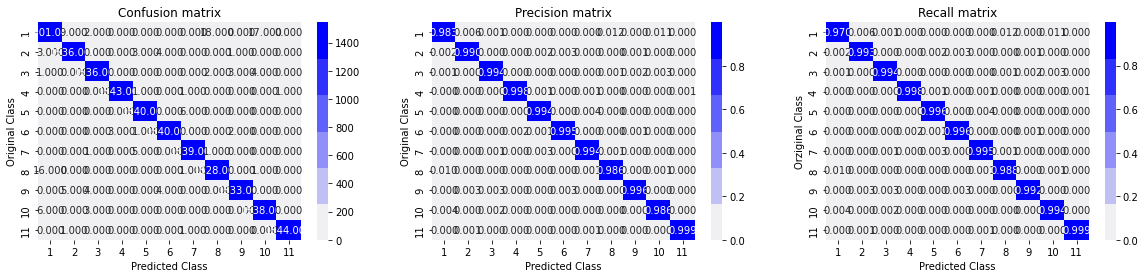

 XGBoost 
              precision    recall  f1-score   support

    Class: 1       1.00      0.90      0.94      1547
    Class: 2       0.98      0.85      0.91      1547
    Class: 3       0.82      0.95      0.88      1546
    Class: 4       0.90      0.99      0.94      1546
    Class: 5       0.88      0.94      0.91      1546
    Class: 6       0.85      0.82      0.84      1546
    Class: 7       0.95      0.77      0.85      1546
    Class: 8       0.91      0.84      0.88      1546
    Class: 9       0.83      0.91      0.87      1546
   Class: 10       0.86      0.95      0.90      1547
   Class: 11       1.00      1.00      1.00      1546

    accuracy                           0.90     17009
   macro avg       0.91      0.90      0.90     17009
weighted avg       0.91      0.90      0.90     17009



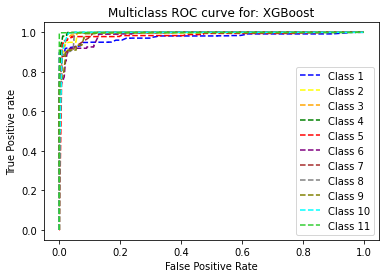

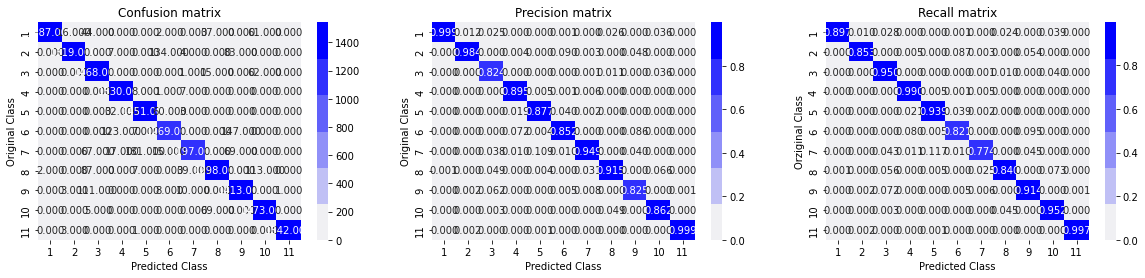

In [ ]:
my_dict = {'Classifier-Names': [], 'Acc': [], 'Log-Loss': [],  'Precision': [],  'Recall': [],  'F1-Score': [], 'Roc-Auc': [] , 'Specificity': [], 'G-Mean' : [], 'TNR': [], 'FNR' : [], 'FPR': [], 'Total-TP': [],  'Total-FP': [], 'Total-TN' : [], 'Total-FN' : []}

train_test(X_train, X_test, y_train, y_test,1)

####**Save and Read the table of Evaluation Matrics.**

In [ ]:
data = pd.DataFrame(my_dict)
data.to_csv('/content/gdrive/MyDrive/Ransom_Benign_with_oversample_BL_SMOTE.csv', encoding='utf-8', index=False)
data = pd.read_csv('/content/gdrive/MyDrive/Ransom_Benign_with_oversample_BL_SMOTE.csv')
data.head()

,Classifier-Names,Acc,Log-Loss,Precision,Recall,F1-Score,Roc-Auc,Specificity,G-Mean,TNR,FNR,FPR,Total-TP,Total-FP,Total-TN,Total-FN
0,Random Forest,0.990946,0.067249,0.991011,0.990946,0.990965,0.999644,0.999095,0.995012,0.999095,0.009054,0.000905,16855,154,169936,154
1,AdaBoost,0.562585,1.225513,0.474283,0.562681,0.464553,0.926549,0.956258,0.733531,0.956258,0.437415,0.043742,9569,7440,162650,7440
2,Gardient Boosting,0.905521,1.518095,0.909093,0.905521,0.905139,0.990621,0.990552,0.947083,0.990552,0.094479,0.009448,15402,1607,168483,1607
3,Logistic Regression,0.272209,2.047359,0.362868,0.272203,0.248819,0.703970,0.927221,0.502386,0.927221,0.727791,0.072779,4630,12379,157711,12379
4,Decision Tree,0.992298,0.266011,0.992296,0.992299,0.992291,0.995765,0.999230,0.995759,0.999230,0.007702,0.000770,16878,131,169959,131


##**ADASYN Technique for oversampling**

Class=10, n=7721 (77.210%)
Class=11, n=7728 (77.280%)
Class=7, n=7814 (78.140%)
Class=6, n=7640 (76.400%)
Class=4, n=7818 (78.180%)
Class=3, n=7657 (76.570%)
Class=5, n=7768 (77.680%)
Class=2, n=7743 (77.430%)
Class=9, n=7739 (77.390%)
Class=8, n=7712 (77.120%)
Class=1, n=7731 (77.310%)


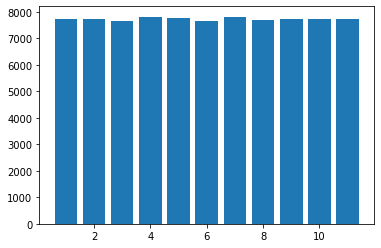

In [ ]:
from pandas import read_csv
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import ADASYN


oversample = ADASYN()
X_ad, y_ad = oversample.fit_resample(X, y)
# summarize distribution
counter = Counter(y_ad)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution

#y2 = pd.Series(y2)
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

####**Spliting data to train and and test.**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_ad, y_ad, stratify = y_ad, test_size = 0.2)
print("Number of data points in train data :", X_train.shape)
print("Number of data points in test data :", X_test.shape)

Number of data points in train data : (68056, 84)
Number of data points in test data : (17015, 84)


####**Calling the function to train and test.**



 Random Forest 
              precision    recall  f1-score   support

    Class: 1       0.99      0.97      0.98      1546
    Class: 2       0.99      1.00      0.99      1549
    Class: 3       0.99      1.00      0.99      1531
    Class: 4       1.00      1.00      1.00      1564
    Class: 5       0.99      0.99      0.99      1554
    Class: 6       1.00      1.00      1.00      1528
    Class: 7       1.00      0.99      1.00      1563
    Class: 8       0.99      1.00      0.99      1542
    Class: 9       1.00      1.00      1.00      1548
   Class: 10       0.99      1.00      0.99      1544
   Class: 11       1.00      1.00      1.00      1546

    accuracy                           0.99     17015
   macro avg       0.99      0.99      0.99     17015
weighted avg       0.99      0.99      0.99     17015



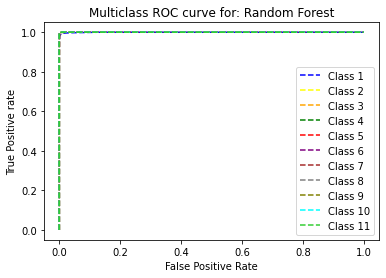

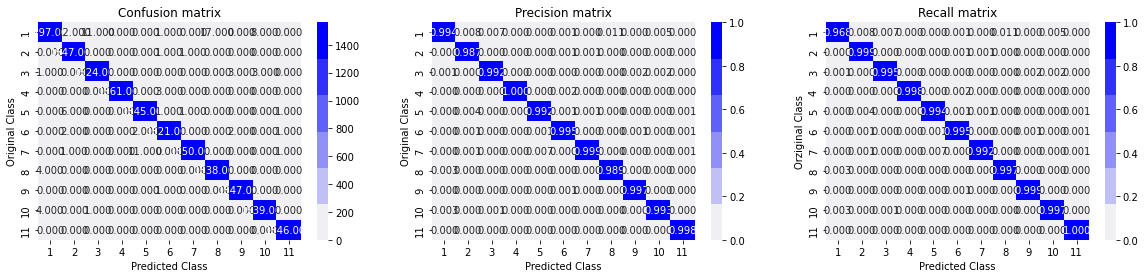

 AdaBoost 


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

              precision    recall  f1-score   support

    Class: 1       0.00      0.00      0.00      1546
    Class: 2       0.36      0.50      0.42      1549
    Class: 3       0.30      0.84      0.44      1531
    Class: 4       0.46      0.99      0.63      1564
    Class: 5       0.82      0.36      0.50      1554
    Class: 6       0.00      0.00      0.00      1528
    Class: 7       0.62      0.85      0.72      1563
    Class: 8       0.78      0.84      0.81      1542
    Class: 9       0.55      0.99      0.71      1548
   Class: 10       0.00      0.00      0.00      1544
   Class: 11       0.00      0.00      0.00      1546

    accuracy                           0.49     17015
   macro avg       0.35      0.49      0.38     17015
weighted avg       0.36      0.49      0.39     17015



<ipython-input-6-504b423498f2>:6: RuntimeWarning: invalid value encountered in true_divide
  B = (C/C.sum(axis=0))


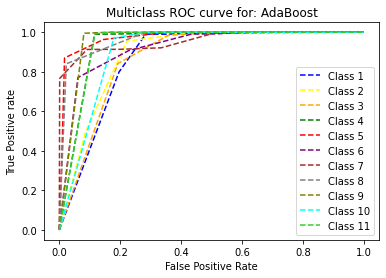

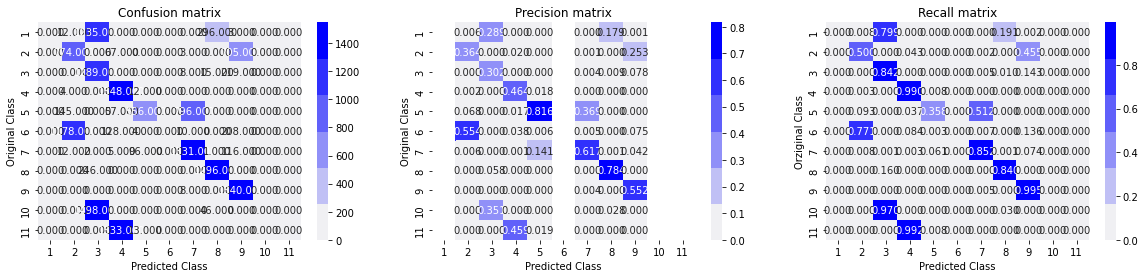

 Gardient Boosting 
              precision    recall  f1-score   support

    Class: 1       1.00      0.90      0.95      1546
    Class: 2       0.99      0.81      0.89      1549
    Class: 3       0.87      0.92      0.89      1531
    Class: 4       0.88      0.95      0.91      1564
    Class: 5       0.86      0.87      0.87      1554
    Class: 6       0.67      0.90      0.77      1528
    Class: 7       0.97      0.79      0.87      1563
    Class: 8       0.93      0.87      0.90      1542
    Class: 9       0.92      0.76      0.83      1548
   Class: 10       0.83      0.98      0.89      1544
   Class: 11       0.90      0.95      0.93      1546

    accuracy                           0.88     17015
   macro avg       0.89      0.88      0.88     17015
weighted avg       0.89      0.88      0.88     17015



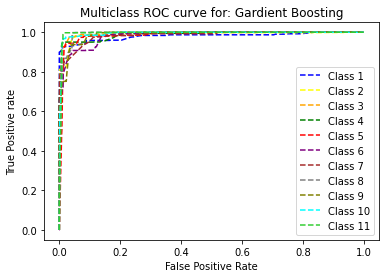

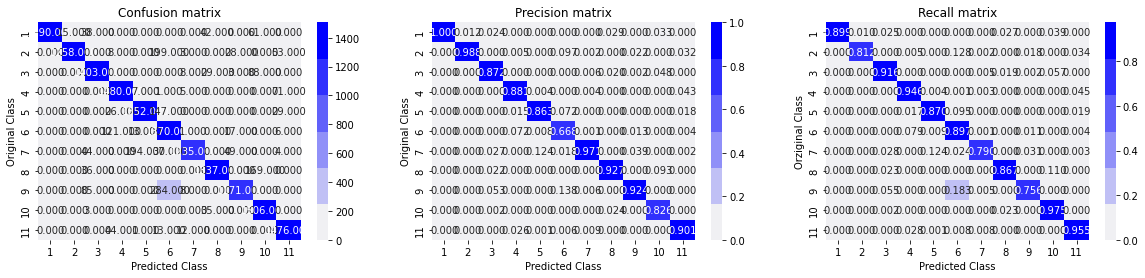

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 Logistic Regression 
              precision    recall  f1-score   support

    Class: 1       0.07      0.01      0.02      1546
    Class: 2       0.10      0.62      0.18      1549
    Class: 3       0.10      0.01      0.01      1531
    Class: 4       0.19      0.12      0.15      1564
    Class: 5       0.14      0.14      0.14      1554
    Class: 6       0.19      0.03      0.05      1528
    Class: 7       0.25      0.04      0.07      1563
    Class: 8       0.12      0.16      0.13      1542
    Class: 9       0.29      0.07      0.12      1548
   Class: 10       0.17      0.15      0.16      1544
   Class: 11       0.69      0.27      0.38      1546

    accuracy                           0.15     17015
   macro avg       0.21      0.15      0.13     17015
weighted avg       0.21      0.15      0.13     17015



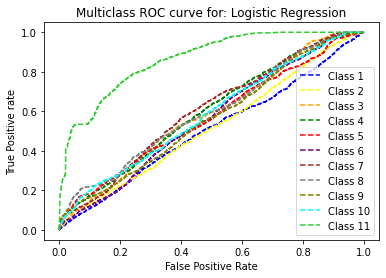

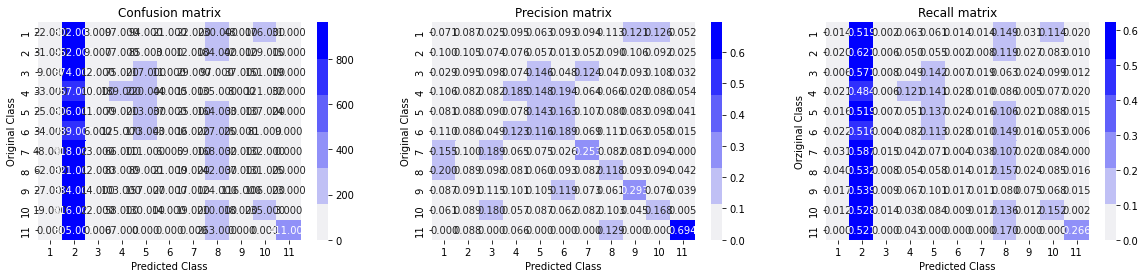

 Decision Tree 
              precision    recall  f1-score   support

    Class: 1       0.97      0.96      0.97      1546
    Class: 2       0.99      0.99      0.99      1549
    Class: 3       0.99      0.99      0.99      1531
    Class: 4       0.99      0.99      0.99      1564
    Class: 5       0.98      0.99      0.98      1554
    Class: 6       0.99      0.99      0.99      1528
    Class: 7       0.99      0.98      0.98      1563
    Class: 8       0.98      0.99      0.99      1542
    Class: 9       0.99      0.99      0.99      1548
   Class: 10       0.98      0.98      0.98      1544
   Class: 11       1.00      1.00      1.00      1546

    accuracy                           0.99     17015
   macro avg       0.99      0.99      0.99     17015
weighted avg       0.99      0.99      0.99     17015



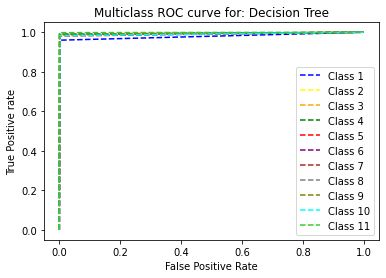

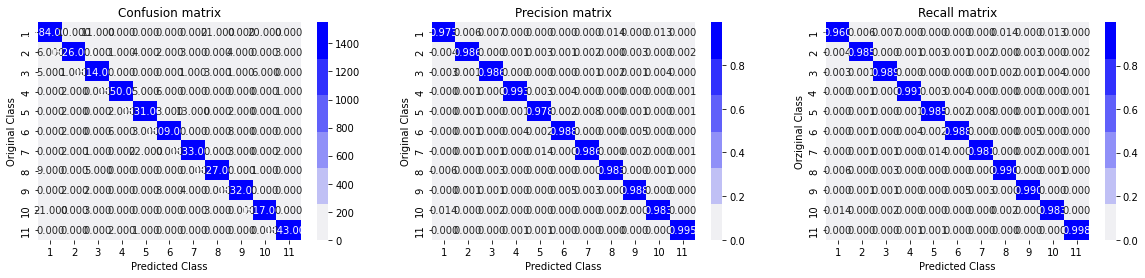

 XGBoost 
              precision    recall  f1-score   support

    Class: 1       1.00      0.90      0.95      1546
    Class: 2       0.99      0.81      0.89      1549
    Class: 3       0.85      0.93      0.89      1531
    Class: 4       0.90      0.94      0.92      1564
    Class: 5       0.86      0.87      0.87      1554
    Class: 6       0.71      0.87      0.78      1528
    Class: 7       0.97      0.79      0.87      1563
    Class: 8       0.94      0.84      0.89      1542
    Class: 9       0.84      0.79      0.81      1548
   Class: 10       0.83      0.98      0.89      1544
   Class: 11       0.90      0.98      0.94      1546

    accuracy                           0.88     17015
   macro avg       0.89      0.88      0.88     17015
weighted avg       0.89      0.88      0.88     17015



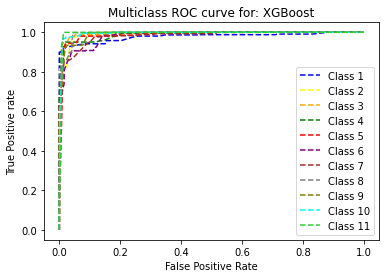

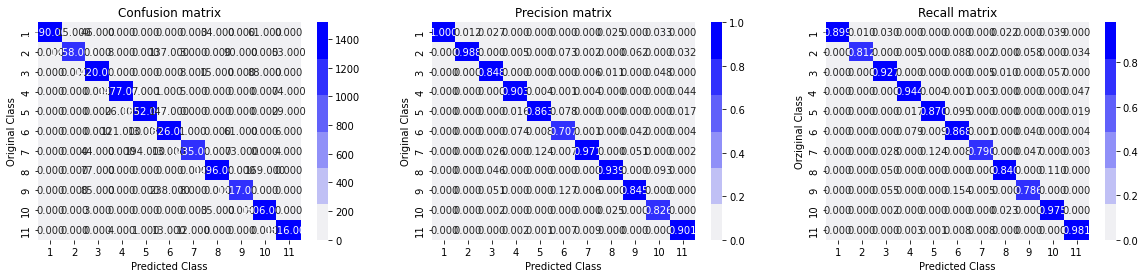

In [ ]:
my_dict = {'Classifier-Names': [], 'Acc': [], 'Log-Loss': [],  'Precision': [],  'Recall': [],  'F1-Score': [], 'Roc-Auc': [] , 'Specificity': [], 'G-Mean' : [], 'TNR': [], 'FNR' : [], 'FPR': [], 'Total-TP': [],  'Total-FP': [], 'Total-TN' : [], 'Total-FN' : []}

train_test(X_train, X_test, y_train, y_test,1)

####**Save and Read the table of Evaluation Matrics.**

In [ ]:
data = pd.DataFrame(my_dict)
data.to_csv('/content/gdrive/MyDrive/Ransom_Benign_with_oversample_ADASYN.csv', encoding='utf-8', index=False)
data = pd.read_csv('/content/gdrive/MyDrive/Ransom_Benign_with_oversample_ADASYN.csv')
data.head()

,Classifier-Names,Acc,Log-Loss,Precision,Recall,F1-Score,Roc-Auc,Specificity,G-Mean,TNR,FNR,FPR,Total-TP,Total-FP,Total-TN,Total-FN
0,Random Forest,0.994123,0.082121,0.994129,0.994123,0.994104,0.999948,0.999412,0.996764,0.999412,0.005877,0.000588,16915,100,170050,100
1,AdaBoost,0.489803,1.234014,0.354453,0.488730,0.384682,0.927665,0.948980,0.681025,0.948980,0.510197,0.051020,8334,8681,161469,8681
2,Gardient Boosting,0.880282,1.550227,0.892690,0.880391,0.881514,0.988321,0.988028,0.932658,0.988028,0.119718,0.011972,14978,2037,168113,2037
3,Logistic Regression,0.147164,2.314576,0.210800,0.146985,0.128819,0.594339,0.914716,0.366674,0.914716,0.852836,0.085284,2504,14511,155639,14511
4,Decision Tree,0.985366,0.505446,0.985353,0.985370,0.985354,0.991953,0.998537,0.991932,0.998537,0.014634,0.001463,16766,249,169901,249


#***Part-5-Train Test with Folding the Dataset:***

####**Function for folding.**

In [ ]:
#my_dict = {'Classifier_Names': [], 'Acc': [], 'Log_L': [],  'Pre': [],  'Rec': [],  'R_Auc': [], 'F1_S': [] , 'All_FP': [], 'All_FN' : [], 'All_TP': [], 'All_TN' : [], 'TNR': [], 'TPR': [],  'FPR': [], 'FNR' : []}
def run_experiment(X, y, X_test, y_test, output_file_name=None, num_folds = None, oversample_method=None):


  mean_before = np.empty((0,))
  mean_after = np.empty((0,))
  std_before = np.empty((0,))
  std_after = np.empty((0,))

  if num_folds == None:
      num_folds = 5

  if output_file_name == None:
      import sys
      output_file_name = sys.argv[0][:-3]+"_output.txt"

  skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=2)
  fold_count = 0
  total_y_pred_p=[]
  t = 1


  for train_index, test_index in skf.split(X, y):


    fold_count += 1
    X_train, _ = X[train_index], X[test_index]
    y_train, _ = y[train_index], y[test_index]

    train_test(X_train, X_test, y_train, y_test, 0)


####**Calling the function to train and test.**

In [ ]:
my_dict = {'Classifier-Names': [], 'Acc': [], 'Log-Loss': [],  'Precision': [],  'Recall': [],  'F1-Score': [], 'Roc-Auc': [] , 'Specificity': [], 'G-Mean' : [], 'TNR': [], 'FNR' : [], 'FPR': [], 'Total-TP': [],  'Total-FP': [], 'Total-TN' : [], 'Total-FN' : []}

run_experiment(X_train, y_train, X_test, y_test)


 Random Forest 
              precision    recall  f1-score   support

    Class: 1       0.99      0.96      0.98      1546
    Class: 2       0.99      1.00      0.99      1549
    Class: 3       0.99      1.00      0.99      1531
    Class: 4       1.00      1.00      1.00      1564
    Class: 5       0.99      0.99      0.99      1554
    Class: 6       0.99      1.00      1.00      1528
    Class: 7       1.00      0.99      1.00      1563
    Class: 8       0.99      1.00      0.99      1542
    Class: 9       1.00      1.00      1.00      1548
   Class: 10       0.99      1.00      0.99      1544
   Class: 11       1.00      1.00      1.00      1546

    accuracy                           0.99     17015
   macro avg       0.99      0.99      0.99     17015
weighted avg       0.99      0.99      0.99     17015

 AdaBoost 


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

              precision    recall  f1-score   support

    Class: 1       0.00      0.00      0.00      1546
    Class: 2       0.36      0.50      0.42      1549
    Class: 3       0.30      0.84      0.44      1531
    Class: 4       0.46      0.99      0.63      1564
    Class: 5       0.82      0.36      0.50      1554
    Class: 6       0.00      0.00      0.00      1528
    Class: 7       0.62      0.85      0.72      1563
    Class: 8       0.78      0.84      0.81      1542
    Class: 9       0.55      0.99      0.71      1548
   Class: 10       0.00      0.00      0.00      1544
   Class: 11       0.00      0.00      0.00      1546

    accuracy                           0.49     17015
   macro avg       0.35      0.49      0.38     17015
weighted avg       0.36      0.49      0.39     17015

 Gardient Boosting 
              precision    recall  f1-score   support

    Class: 1       1.00      0.90      0.95      1546
    Class: 2       0.99      0.81      0.89      1549
    

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 Logistic Regression 
              precision    recall  f1-score   support

    Class: 1       0.12      0.02      0.03      1546
    Class: 2       0.22      0.04      0.07      1549
    Class: 3       0.10      0.01      0.02      1531
    Class: 4       0.19      0.09      0.12      1564
    Class: 5       0.09      0.69      0.17      1554
    Class: 6       0.30      0.03      0.06      1528
    Class: 7       0.21      0.04      0.07      1563
    Class: 8       0.15      0.15      0.15      1542
    Class: 9       0.32      0.05      0.09      1548
   Class: 10       0.15      0.14      0.15      1544
   Class: 11       0.69      0.27      0.39      1546

    accuracy                           0.14     17015
   macro avg       0.23      0.14      0.12     17015
weighted avg       0.23      0.14      0.12     17015

 Decision Tree 
              precision    recall  f1-score   support

    Class: 1       0.97      0.96      0.96      1546
    Class: 2       0.98      0.98      0

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

              precision    recall  f1-score   support

    Class: 1       0.00      0.00      0.00      1546
    Class: 2       0.36      0.50      0.42      1549
    Class: 3       0.30      0.84      0.44      1531
    Class: 4       0.46      0.99      0.63      1564
    Class: 5       0.82      0.36      0.50      1554
    Class: 6       0.00      0.00      0.00      1528
    Class: 7       0.62      0.85      0.72      1563
    Class: 8       0.78      0.84      0.81      1542
    Class: 9       0.55      0.99      0.71      1548
   Class: 10       0.00      0.00      0.00      1544
   Class: 11       0.00      0.00      0.00      1546

    accuracy                           0.49     17015
   macro avg       0.35      0.49      0.38     17015
weighted avg       0.36      0.49      0.39     17015

 Gardient Boosting 
              precision    recall  f1-score   support

    Class: 1       1.00      0.90      0.95      1546
    Class: 2       0.99      0.81      0.89      1549
    

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 Logistic Regression 
              precision    recall  f1-score   support

    Class: 1       0.10      0.03      0.04      1546
    Class: 2       0.11      0.32      0.16      1549
    Class: 3       0.13      0.02      0.03      1531
    Class: 4       0.10      0.33      0.15      1564
    Class: 5       0.10      0.18      0.13      1554
    Class: 6       0.31      0.03      0.05      1528
    Class: 7       0.12      0.03      0.04      1563
    Class: 8       0.18      0.15      0.17      1542
    Class: 9       0.30      0.05      0.08      1548
   Class: 10       0.16      0.15      0.15      1544
   Class: 11       0.67      0.27      0.38      1546

    accuracy                           0.14     17015
   macro avg       0.21      0.14      0.13     17015
weighted avg       0.21      0.14      0.13     17015

 Decision Tree 
              precision    recall  f1-score   support

    Class: 1       0.97      0.95      0.96      1546
    Class: 2       0.98      0.98      0

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

              precision    recall  f1-score   support

    Class: 1       0.00      0.00      0.00      1546
    Class: 2       0.00      0.00      0.00      1549
    Class: 3       0.30      0.84      0.44      1531
    Class: 4       0.46      0.99      0.63      1564
    Class: 5       0.84      0.87      0.85      1554
    Class: 6       0.55      0.77      0.64      1528
    Class: 7       0.98      0.77      0.86      1563
    Class: 8       0.78      0.84      0.81      1542
    Class: 9       0.55      0.99      0.71      1548
   Class: 10       0.00      0.00      0.00      1544
   Class: 11       0.00      0.00      0.00      1546

    accuracy                           0.55     17015
   macro avg       0.41      0.55      0.45     17015
weighted avg       0.41      0.55      0.45     17015

 Gardient Boosting 
              precision    recall  f1-score   support

    Class: 1       1.00      0.90      0.95      1546
    Class: 2       0.99      0.81      0.89      1549
    

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 Logistic Regression 
              precision    recall  f1-score   support

    Class: 1       0.09      0.60      0.16      1546
    Class: 2       0.18      0.05      0.07      1549
    Class: 3       0.16      0.05      0.08      1531
    Class: 4       0.20      0.07      0.10      1564
    Class: 5       0.16      0.11      0.13      1554
    Class: 6       0.26      0.03      0.05      1528
    Class: 7       0.17      0.03      0.05      1563
    Class: 8       0.16      0.17      0.16      1542
    Class: 9       0.37      0.05      0.09      1548
   Class: 10       0.17      0.16      0.16      1544
   Class: 11       0.74      0.28      0.40      1546

    accuracy                           0.14     17015
   macro avg       0.24      0.14      0.13     17015
weighted avg       0.24      0.14      0.13     17015

 Decision Tree 
              precision    recall  f1-score   support

    Class: 1       0.97      0.96      0.97      1546
    Class: 2       0.98      0.98      0

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

              precision    recall  f1-score   support

    Class: 1       0.00      0.00      0.00      1546
    Class: 2       0.36      0.50      0.42      1549
    Class: 3       0.30      0.84      0.44      1531
    Class: 4       0.46      0.99      0.63      1564
    Class: 5       0.82      0.36      0.50      1554
    Class: 6       0.00      0.00      0.00      1528
    Class: 7       0.62      0.85      0.72      1563
    Class: 8       0.78      0.84      0.81      1542
    Class: 9       0.55      0.99      0.71      1548
   Class: 10       0.00      0.00      0.00      1544
   Class: 11       0.00      0.00      0.00      1546

    accuracy                           0.49     17015
   macro avg       0.35      0.49      0.38     17015
weighted avg       0.36      0.49      0.39     17015

 Gardient Boosting 
              precision    recall  f1-score   support

    Class: 1       1.00      0.90      0.95      1546
    Class: 2       0.99      0.81      0.89      1549
    

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 Logistic Regression 
              precision    recall  f1-score   support

    Class: 1       0.10      0.02      0.03      1546
    Class: 2       0.10      0.33      0.16      1549
    Class: 3       0.18      0.03      0.05      1531
    Class: 4       0.10      0.43      0.16      1564
    Class: 5       0.10      0.12      0.11      1554
    Class: 6       0.30      0.03      0.05      1528
    Class: 7       0.23      0.02      0.05      1563
    Class: 8       0.19      0.16      0.18      1542
    Class: 9       0.35      0.05      0.09      1548
   Class: 10       0.21      0.06      0.09      1544
   Class: 11       0.69      0.27      0.39      1546

    accuracy                           0.14     17015
   macro avg       0.23      0.14      0.12     17015
weighted avg       0.23      0.14      0.12     17015

 Decision Tree 
              precision    recall  f1-score   support

    Class: 1       0.98      0.96      0.97      1546
    Class: 2       0.98      0.98      0

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

              precision    recall  f1-score   support

    Class: 1       0.00      0.00      0.00      1546
    Class: 2       0.36      0.50      0.42      1549
    Class: 3       0.30      0.84      0.44      1531
    Class: 4       0.46      0.99      0.63      1564
    Class: 5       0.82      0.36      0.50      1554
    Class: 6       0.25      0.00      0.00      1528
    Class: 7       0.62      0.85      0.72      1563
    Class: 8       0.78      0.84      0.81      1542
    Class: 9       0.55      0.99      0.71      1548
   Class: 10       0.00      0.00      0.00      1544
   Class: 11       0.00      0.00      0.00      1546

    accuracy                           0.49     17015
   macro avg       0.38      0.49      0.39     17015
weighted avg       0.38      0.49      0.39     17015

 Gardient Boosting 
              precision    recall  f1-score   support

    Class: 1       1.00      0.90      0.95      1546
    Class: 2       0.99      0.81      0.89      1549
    

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 Logistic Regression 
              precision    recall  f1-score   support

    Class: 1       0.15      0.01      0.02      1546
    Class: 2       0.10      0.71      0.17      1549
    Class: 3       0.11      0.01      0.01      1531
    Class: 4       0.19      0.06      0.10      1564
    Class: 5       0.14      0.12      0.13      1554
    Class: 6       0.28      0.02      0.04      1528
    Class: 7       0.16      0.04      0.07      1563
    Class: 8       0.18      0.16      0.17      1542
    Class: 9       0.30      0.08      0.12      1548
   Class: 10       0.18      0.10      0.13      1544
   Class: 11       0.67      0.27      0.38      1546

    accuracy                           0.14     17015
   macro avg       0.22      0.14      0.12     17015
weighted avg       0.22      0.14      0.12     17015

 Decision Tree 
              precision    recall  f1-score   support

    Class: 1       0.98      0.96      0.97      1546
    Class: 2       0.99      0.98      0

####**Save and Read the table of Evaluation Matrics.**####

In [ ]:
data = pd.DataFrame(my_dict)
data.to_csv('/content/gdrive/MyDrive/Ransom_Benign_with_Fold.csv', encoding='utf-8', index=False)
data = pd.read_csv('/content/gdrive/MyDrive/Ransom_Benign_with_Fold.csv')
data.head()

,Classifier-Names,Acc,Log-Loss,Precision,Recall,F1-Score,Roc-Auc,Specificity,G-Mean,TNR,FNR,FPR,Total-TP,Total-FP,Total-TN,Total-FN
0,Random Forest,0.993535,0.106565,0.993542,0.993537,0.993512,0.999857,0.999354,0.996441,0.999354,0.006465,0.000646,16905,110,170040,110
1,AdaBoost,0.489744,1.233405,0.354394,0.488672,0.384628,0.927712,0.948974,0.680983,0.948974,0.510256,0.051026,8333,8682,161468,8682
2,Gardient Boosting,0.882927,1.549695,0.895084,0.883042,0.884049,0.988214,0.988293,0.934186,0.988293,0.117073,0.011707,15023,1992,168158,1992
3,Logistic Regression,0.139641,2.298874,0.231858,0.139339,0.118695,0.597553,0.913964,0.356862,0.913964,0.860359,0.086036,2376,14639,155511,14639
4,Decision Tree,0.983133,0.582582,0.983141,0.983132,0.983129,0.990723,0.998313,0.990694,0.998313,0.016867,0.001687,16728,287,169863,287


###**Feature Importance**

Feature: 0, Scoricatione: 0.00712
Feature: 1, Scoricatione: 0.18123
Feature: 2, Scoricatione: 0.00000
Feature: 3, Scoricatione: 0.02012
Feature: 4, Scoricatione: 0.00048
Feature: 5, Scoricatione: 0.00000
Feature: 6, Scoricatione: 0.77963
Feature: 7, Scoricatione: 0.00059
Feature: 8, Scoricatione: 0.00000
Feature: 9, Scoricatione: 0.00000
Feature: 10, Scoricatione: 0.00000
Feature: 11, Scoricatione: 0.00000
Feature: 12, Scoricatione: 0.00000
Feature: 13, Scoricatione: 0.00000
Feature: 14, Scoricatione: 0.00000
Feature: 15, Scoricatione: 0.00000
Feature: 16, Scoricatione: 0.00000
Feature: 17, Scoricatione: 0.00000
Feature: 18, Scoricatione: 0.00000
Feature: 19, Scoricatione: 0.00000
Feature: 20, Scoricatione: 0.00000
Feature: 21, Scoricatione: 0.00125
Feature: 22, Scoricatione: 0.00000
Feature: 23, Scoricatione: 0.00000
Feature: 24, Scoricatione: 0.00000
Feature: 25, Scoricatione: 0.00063
Feature: 26, Scoricatione: 0.00000
Feature: 27, Scoricatione: 0.00150
Feature: 28, Scoricatione: 0.0

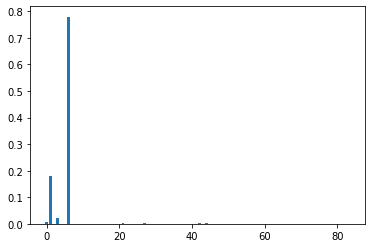

In [ ]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
# define the model
model = DecisionTreeClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Scoricatione: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()